# Lib importing

In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
!pip install pydicom

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import pydicom
from keras.applications.mobilenet import MobileNet, preprocess_input
from sklearn.utils import shuffle
import matplotlib.patches as patches
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score,precision_score,recall_score,f1_score
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape, Concatenate, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve
from tensorflow.keras import regularizers
from tensorflow.keras.applications.densenet import DenseNet121
from keras.models import model_from_json

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import zscore
from sklearn.utils import resample
from imblearn import over_sampling as samp
from  sklearn.decomposition import PCA

import os
import pickle
from pydicom.filereader import read_dicomdir
from matplotlib import style
from matplotlib import patches
style.use('ggplot')
import h5py
#%matplotlib inline

In [0]:
#TO extract data folder from zip file
from zipfile import ZipFile
with ZipFile('/content/drive/My Drive/capstone/stage_2_train_images.zip', 'r') as z:
    z.extractall()

In [0]:
#Import dataset
df_train=pd.read_csv('/content/drive/My Drive/capstone/stage_2_train_labels.csv')

In [11]:
#Cross check step to see data is loaded properly
df_train.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [0]:
#replacind nan with 0
df_train['x'] = df_train['x'].fillna(0)
df_train['y'] = df_train['y'].fillna(0)
df_train['width'] = df_train['width'].fillna(0)
df_train['height'] = df_train['height'].fillna(0)

In [0]:
#This step append 
path = "/content/stage_2_train_images/"
colu=[]
for i,j in enumerate(df_train['patientId']):
    colu.append(os.path.join(path, df_train.iloc[i,0]))

ext='.dcm'
z=[]
for i in colu:
    k=i+ext
    z.append(k)

In [14]:
colu=np.array(z)
df_train['patientId1'] = pd.DataFrame(z)    
df_train.drop(["patientId"], axis = 1, inplace = True)
df_train=df_train[['patientId1','x','y','width','height','Target']]
df_train.head(10)

,patientId1,x,y,width,height,Target
0,/content/stage_2_train_images/0004cfab-14fd-4e...,0.0,0.0,0.0,0.0,0
1,/content/stage_2_train_images/00313ee0-9eaa-42...,0.0,0.0,0.0,0.0,0
2,/content/stage_2_train_images/00322d4d-1c29-49...,0.0,0.0,0.0,0.0,0
3,/content/stage_2_train_images/003d8fa0-6bf1-40...,0.0,0.0,0.0,0.0,0
4,/content/stage_2_train_images/00436515-870c-4b...,264.0,152.0,213.0,379.0,1
5,/content/stage_2_train_images/00436515-870c-4b...,562.0,152.0,256.0,453.0,1
6,/content/stage_2_train_images/00569f44-917d-4c...,0.0,0.0,0.0,0.0,0
7,/content/stage_2_train_images/006cec2e-6ce2-45...,0.0,0.0,0.0,0.0,0
8,/content/stage_2_train_images/00704310-78a8-4b...,323.0,577.0,160.0,104.0,1
9,/content/stage_2_train_images/00704310-78a8-4b...,695.0,575.0,162.0,137.0,1


In [15]:
n=19
x1 = int(df_train.iloc[n,1])
y1 = int(df_train.iloc[n,2])
wt = int(df_train.iloc[n,3])
ht = int(df_train.iloc[n,4])
print(x1,y1,wt,ht)

181 184 206 506


#From here we have reduced data 

In [16]:
#selecting 1 cases and storing in new dataframe
df=df_train[df_train['Target']==1]
df.head()

,patientId1,x,y,width,height,Target
4,/content/stage_2_train_images/00436515-870c-4b...,264.0,152.0,213.0,379.0,1
5,/content/stage_2_train_images/00436515-870c-4b...,562.0,152.0,256.0,453.0,1
8,/content/stage_2_train_images/00704310-78a8-4b...,323.0,577.0,160.0,104.0,1
9,/content/stage_2_train_images/00704310-78a8-4b...,695.0,575.0,162.0,137.0,1
14,/content/stage_2_train_images/00aecb01-a116-45...,288.0,322.0,94.0,135.0,1


In [17]:
#selecting 0 cases and storing in new dataframe
df2=df_train[df_train['Target']==0]
df2.head()

,patientId1,x,y,width,height,Target
0,/content/stage_2_train_images/0004cfab-14fd-4e...,0.0,0.0,0.0,0.0,0
1,/content/stage_2_train_images/00313ee0-9eaa-42...,0.0,0.0,0.0,0.0,0
2,/content/stage_2_train_images/00322d4d-1c29-49...,0.0,0.0,0.0,0.0,0
3,/content/stage_2_train_images/003d8fa0-6bf1-40...,0.0,0.0,0.0,0.0,0
6,/content/stage_2_train_images/00569f44-917d-4c...,0.0,0.0,0.0,0.0,0


In [0]:
#Selecting data based on slicing
#Here we delebratelly choosing 1 to be little more as our main aim is to predict 1
df=df.iloc[0:5700,:]
df2=df2.iloc[0:4300,:]

In [0]:
#appending data df3 to df2
#now df3 is my final reduced dataset used for model
df3 = df.append(df2)

In [20]:
df3.head(10)

,patientId1,x,y,width,height,Target
4,/content/stage_2_train_images/00436515-870c-4b...,264.0,152.0,213.0,379.0,1
5,/content/stage_2_train_images/00436515-870c-4b...,562.0,152.0,256.0,453.0,1
8,/content/stage_2_train_images/00704310-78a8-4b...,323.0,577.0,160.0,104.0,1
9,/content/stage_2_train_images/00704310-78a8-4b...,695.0,575.0,162.0,137.0,1
14,/content/stage_2_train_images/00aecb01-a116-45...,288.0,322.0,94.0,135.0,1
15,/content/stage_2_train_images/00aecb01-a116-45...,547.0,299.0,119.0,165.0,1
16,/content/stage_2_train_images/00c0b293-48e7-4e...,306.0,544.0,168.0,244.0,1
17,/content/stage_2_train_images/00c0b293-48e7-4e...,650.0,511.0,206.0,284.0,1
19,/content/stage_2_train_images/00f08de1-517e-46...,181.0,184.0,206.0,506.0,1
20,/content/stage_2_train_images/00f08de1-517e-46...,571.0,275.0,230.0,476.0,1


In [0]:
#random shuffle 20 times
for _ in range(20):
    df3 = shuffle(df3)

In [22]:
#Resizing image to 228*228
IMAGE_HEIGHT = 228
IMAGE_WIDTH = 228
num=10000
X_train=0
X_train = np.zeros((num, IMAGE_HEIGHT, IMAGE_WIDTH))
for index in range(num):
    img = pydicom.read_file(df3.iloc[index,0])
    img = img.pixel_array
    if index==3:
        print(img.shape)
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    #print(img)
    X_train[index] = img
    

(1024, 1024)


In [23]:
X_train.shape

(10000, 228, 228)

[[157. 112.  23. ...   6.   6.   6.]
 [144.  71.   7. ...   6.   6.   6.]
 [134.  65.   8. ...   6.   6.   6.]
 ...
 [168. 115.  19. ...   6.   6.   6.]
 [176. 119.  24. ...   8.   8.   6.]
 [185. 125.  44. ...  23.  23.  27.]]


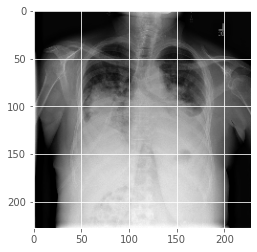

In [24]:
n = 10
print(X_train[n])
plt.imshow(X_train[n], cmap=plt.cm.gray)

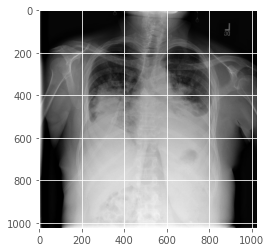

In [25]:
img = pydicom.read_file(df3.iloc[10,0])
img = img.pixel_array
plt.imshow(img, cmap=plt.cm.gray)

In [0]:
#converting bound box to 
coords = np.zeros((int(num), 4), dtype=int)
for index in range(num):
    coords[index,0] = df3.iloc[index,1] * 228 / 1024
    coords[index,1] = df3.iloc[index,2] * 228 / 1024
    coords[index,2] = df3.iloc[index,3] * 228 / 1024
    coords[index,3] = df3.iloc[index,4] * 228 / 1024
    

In [27]:
#Cross check random image bound box
n=5

print(df3.iloc[n,1])
print(df3.iloc[n,2])
print(df3.iloc[n,3])
print(df3.iloc[n,4])

print('\n')
print(coords[n,0])
print(coords[n,1])
print(coords[n,2])
print(coords[n,3])

263.0
455.0
126.0
184.0


58
101
28
40


In [0]:
#Selecting y label based
y_train=df3.iloc[0:num,-1].values

In [29]:
print(y_train.shape)
print(X_train.shape)
print(coords.shape)

(10000,)
(10000, 228, 228)
(10000, 4)


In [30]:
y_train[1]

0

In [31]:
#reshape the image
X_train1 = X_train.reshape(X_train.shape[0], 228, 228, 1)
X_train1.shape

(10000, 228, 228, 1)

In [32]:
#Normalizing the image
X_train1 = X_train1.astype('float32')

#Normalizing the input
X_train1 /= 255.0
print('x_train shape:', X_train1.shape)


x_train shape: (10000, 228, 228, 1)


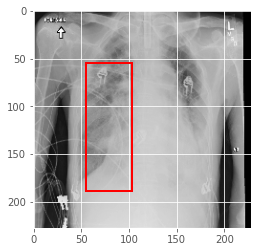

1


In [33]:
#plotting a image with bound box and print label
n=151
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(X_train1[n].reshape(228,228), cmap=plt.cm.gray)

# Create a Rectangle patch
rect = patches.Rectangle((coords[n,0], coords[n,0]), (coords[n,2]) , (coords[n,3]) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


print(y_train[n])

In [0]:
#Splitting data into train,test and validation set
X_train, X_test1, y_train, y_test1 = train_test_split(X_train1, y_train, test_size=0.37, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.27, random_state=42)

In [35]:
#cross check step for checking shape of final data
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print("\n")
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(6300, 228, 228, 1)
(2700, 228, 228, 1)
(1000, 228, 228, 1)


(6300,)
(2700,)
(1000,)


## Basic CNN Model

In [0]:
#Defining image size
IMAGE_HEIGHT = 228
IMAGE_WIDTH = 228

In [46]:
#Model building
shape_input = (IMAGE_HEIGHT,IMAGE_WIDTH,1)
model = Sequential()
model.add(Conv2D(128,kernel_size=(3,3),activation='relu',input_shape=shape_input))
model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(8,kernel_size=(4,4),activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))
#sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.03)
sgd_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 226, 226, 128)     1280      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 224, 224, 64)      73792     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 108, 108, 32)      51232     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 52, 52, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 16)       

In [47]:
#defining call backs
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)
model_check=ModelCheckpoint(
    filepath='/content/drive/My Drive/Colab Notebooks/Capstone Project/model_cnn_checkpoint',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
    )
history=model.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          callbacks=[early_stopping_monitor,model_check],
          epochs=10,
          batch_size=70)
          #steps_per_epoch=50)

Epoch 1/10
90/90 [==============================] - 130s 1s/step - loss: 0.6052 - accuracy: 0.6751 - val_loss: 0.6273 - val_accuracy: 0.6696
Epoch 2/10
90/90 [==============================] - 130s 1s/step - loss: 0.5381 - accuracy: 0.7394 - val_loss: 0.5723 - val_accuracy: 0.7296
Epoch 3/10
90/90 [==============================] - 127s 1s/step - loss: 0.5255 - accuracy: 0.7525 - val_loss: 0.5428 - val_accuracy: 0.7226
Epoch 4/10
90/90 [==============================] - 127s 1s/step - loss: 0.5182 - accuracy: 0.7590 - val_loss: 0.9939 - val_accuracy: 0.4589
Epoch 5/10
90/90 [==============================] - 131s 1s/step - loss: 0.5140 - accuracy: 0.7581 - val_loss: 0.5334 - val_accuracy: 0.7393
Epoch 6/10
90/90 [==============================] - 130s 1s/step - loss: 0.5036 - accuracy: 0.7684 - val_loss: 0.5275 - val_accuracy: 0.7604
Epoch 7/10
90/90 [==============================] - 130s 1s/step - loss: 0.4935 - accuracy: 0.7740 - val_loss: 0.4957 - val_accuracy: 0.7615
Epoch 8/10
90

In [48]:
#Confusion Matrix
y_pred=(model.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred),'\n')
print('Classification Report:\n',classification_report(y_test,y_pred),'\n')
print('Accuracy Score:\n',accuracy_score(y_test,y_pred),'\n')
eval=model.evaluate(X_test,y_test,verbose=0)
print('Model Evaluation Loss :\n',eval[0])
print('Model Evaluation Accuracy :\n',eval[1])

Confusion Matrix:
 [[191 230]
 [ 41 538]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.45      0.58       421
           1       0.70      0.93      0.80       579

    accuracy                           0.73      1000
   macro avg       0.76      0.69      0.69      1000
weighted avg       0.75      0.73      0.71      1000
 

Accuracy Score:
 0.729 

Model Evaluation Loss :
 0.576711893081665
Model Evaluation Accuracy :
 0.7289999723434448


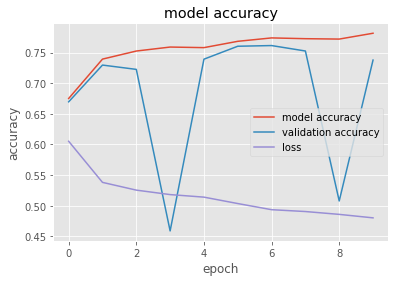

In [49]:
style.use('ggplot')
plt.plot(history.history['accuracy'],label='model accuracy')
plt.plot(history.history['val_accuracy'],label='validation accuracy')
plt.plot(history.history['loss'],label='loss')
plt.title('Basic model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

Improvised CNN model

In [0]:
input_shape = (228, 228, 1)

In [0]:
#model building
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))

#model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


In [65]:
#print model summary
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 226, 226, 64)      640       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 113, 113, 64)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 113, 113, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 111, 111, 32)      18464     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 55, 55, 32)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 96800)            

In [0]:
#Compiling model
#sgd = optimizers.SGD(lr = 0.001)
#model.compile(optimizer = sgd, loss='binary_crossentropy', metrics = ['accuracy'])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [67]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=4, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [68]:
#fitting model to traing set
r = model.fit(
  X_train,
  y_train,
  batch_size=70,
  epochs=10,
  validation_data=(X_val,y_val),
  callbacks=[checkpoint, reduce_lr, stop],
  verbose=1
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.7204 - accuracy: 0.6548
Epoch 00001: val_accuracy improved from -inf to 0.73000, saving model to model-0.72.h5
90/90 [==============================] - 28s 307ms/step - loss: 0.7204 - accuracy: 0.6548 - val_loss: 0.5532 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.5133 - accuracy: 0.7592
Epoch 00002: val_accuracy improved from 0.73000 to 0.75630, saving model to model-0.51.h5
90/90 [==============================] - 27s 301ms/step - loss: 0.5133 - accuracy: 0.7592 - val_loss: 0.5162 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.7641
Epoch 00003: val_accuracy did not improve from 0.75630
90/90 [==============================] - 27s 299ms/step - loss: 0.5074 - accuracy: 0.7641 - val_loss: 0.5237 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
90/90 [==============================] -

In [69]:
#predicting one image from validation step
n=121
img=X_val[n].reshape(1,228,228,1)
k=model.predict(img)
print(k)
print(y_val[n])

[[0.9293479]]
1


In [70]:
#Evaluate validation set and then print accuracy
results = model.evaluate(X_val, y_val)
print('accuracy: ', results[1])

85/85 [==============================] - 5s 53ms/step - loss: 0.5261 - accuracy: 0.7648
accuracy:  0.7648147940635681


In [0]:
#Getting prediction of test set
prediction_test = model.predict(X_test)

In [0]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((1000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [73]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred),'\n')
print(metrics.classification_report(y_test,pred))

accuracy : 0.7710
F1 score : 0.8093
precision score : 0.7814
recall score : 0.8394
Confusion Matrix:
 [[285 136]
 [ 93 486]] 

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       421
           1       0.78      0.84      0.81       579

    accuracy                           0.77      1000
   macro avg       0.77      0.76      0.76      1000
weighted avg       0.77      0.77      0.77      1000



In [74]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.8440713983893929


In [78]:
#predicting 1 test image
n=125
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,228,228,1) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_train[n])

X_test shape =  (1000, 228, 228, 1)
Shape of x =  (228, 228, 1)
New Shape of x =  (1, 228, 228, 1)


Predicted review =  1
Actual value =  1


In [79]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [0.7204421758651733, 0.5133098363876343, 0.5074086785316467, 0.48721709847450256, 0.468265175819397, 0.4409917891025543, 0.4025815427303314, 0.3842627704143524, 0.3750933110713959, 0.37201517820358276], 'accuracy': [0.6547619104385376, 0.7592063546180725, 0.7641269564628601, 0.7746031880378723, 0.7850793600082397, 0.799047589302063, 0.81634920835495, 0.8252381086349487, 0.8333333134651184, 0.8319047689437866], 'val_loss': [0.5531591773033142, 0.5162366032600403, 0.5237092971801758, 0.5131043195724487, 0.5195426344871521, 0.5269945859909058, 0.5224007368087769, 0.5284585952758789, 0.5230433344841003, 0.5261417627334595], 'val_accuracy': [0.7300000190734863, 0.7562962770462036, 0.75, 0.7629629373550415, 0.75, 0.754444420337677, 0.7518518567085266, 0.7596296072006226, 0.762592613697052, 0.7648147940635681], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001, 0.00020000001, 4.0000003e-05, 4.0000003e-05]}


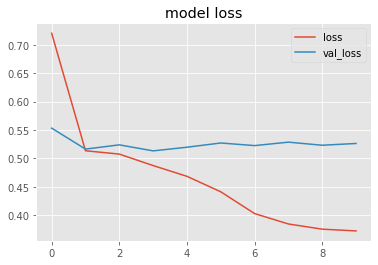

In [81]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.legend()
plt.show()

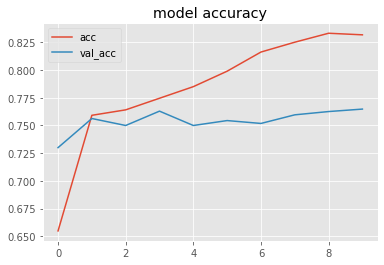

In [82]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.legend()
plt.show()

#### Note: From VGG16 to VGG19 the approach we took is first adding a convolution layer so that our images of single channel are converted to three channel and after that we are passing that output to our pre trained model and at the end we are passing the output from pretrained  to the input of our custom layers to predict our output

### VGG16

In [83]:
#Model building
input_tensor = Input(shape=(228,228,1) )
x2 = Conv2D(3, (3,3), padding='same', name="coords1")(input_tensor) 

model = VGG16(include_top=False, input_shape=(228, 228, 3), weights = "imagenet")


for layer in model.layers:
    layer.trainable = False
    
x1 = model(x2)

#x1 = model.layers[-1].output
x = Conv2D(3, (6,6), name="coords2")(x1)
x = Dropout(0.4)(x)


x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=x)

58892288/58889256 [==============================] - 1s 0us/step


In [84]:
#print model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 228, 228, 1)]     0         
_________________________________________________________________
coords1 (Conv2D)             (None, 228, 228, 3)       30        
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
coords2 (Conv2D)             (None, 2, 2, 3)           55299     
_________________________________________________________________
dropout_14 (Dropout)         (None, 2, 2, 3)           0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               1664  

In [0]:
#Compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [87]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=4, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [88]:
#fitting model to traing set
r = model.fit(
  X_train,
  y_train,
  batch_size=70,
  epochs=10,
  validation_data=(X_val,y_val),
  callbacks=[checkpoint, reduce_lr, stop],
  verbose=1
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.5778 - accuracy: 0.6992
Epoch 00001: val_accuracy improved from -inf to 0.76704, saving model to model-0.58.h5
90/90 [==============================] - 160s 2s/step - loss: 0.5778 - accuracy: 0.6992 - val_loss: 0.5025 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.5160 - accuracy: 0.7667
Epoch 00002: val_accuracy did not improve from 0.76704
90/90 [==============================] - 156s 2s/step - loss: 0.5160 - accuracy: 0.7667 - val_loss: 0.5032 - val_accuracy: 0.7593 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.4654 - accuracy: 0.7941
Epoch 00003: val_accuracy improved from 0.76704 to 0.79111, saving model to model-0.47.h5
90/90 [==============================] - 157s 2s/step - loss: 0.4654 - accuracy: 0.7941 - val_loss: 0.4523 - val_accuracy: 0.7911 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - ETA: 

In [89]:
#predicting one image from validation step
n=121
img=X_val[n].reshape(1,228,228,1)
k=model.predict(img)
print(k)
print(y_val[n])

[[0.9157621]]
1


In [90]:
#Evaluate validation set and then print accuracy
results = model.evaluate(X_val, y_val)
print('accuracy: ', results[1])

85/85 [==============================] - 29s 338ms/step - loss: 0.4342 - accuracy: 0.8048
accuracy:  0.8048148155212402


In [0]:
#Getting prediction of test set
prediction_test = model.predict(X_test)

In [0]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((1000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [93]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred),'\n')
print(metrics.classification_report(y_test,pred))

accuracy : 0.8050
F1 score : 0.8306
precision score : 0.8357
recall score : 0.8256
Confusion Matrix:
 [[327  94]
 [101 478]] 

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       421
           1       0.84      0.83      0.83       579

    accuracy                           0.81      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.81      0.81      0.81      1000



In [94]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.8823058840904334


In [95]:
#prediction of 1 image
n=301
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,228,228,1) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_test[n])

X_test shape =  (1000, 228, 228, 1)
Shape of x =  (228, 228, 1)
New Shape of x =  (1, 228, 228, 1)


Predicted review =  0
Actual value =  0


In [96]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [0.5778491497039795, 0.5159827470779419, 0.46536803245544434, 0.4622693955898285, 0.4397476017475128, 0.420001357793808, 0.41709545254707336, 0.40241533517837524, 0.3869202136993408, 0.3462977409362793], 'accuracy': [0.6992063522338867, 0.7666666507720947, 0.7941269874572754, 0.7928571701049805, 0.8033333420753479, 0.8209523558616638, 0.8180952668190002, 0.8198412656784058, 0.8349206447601318, 0.8560317754745483], 'val_loss': [0.502513587474823, 0.5031753778457642, 0.4522634446620941, 0.44328704476356506, 0.44039416313171387, 0.5219946503639221, 0.4340128004550934, 0.47527506947517395, 0.4586804509162903, 0.4342444837093353], 'val_accuracy': [0.767037034034729, 0.7592592835426331, 0.7911111116409302, 0.7903703451156616, 0.7981481552124023, 0.7777777910232544, 0.7948148250579834, 0.779629647731781, 0.8003703951835632, 0.8048148155212402], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001]}


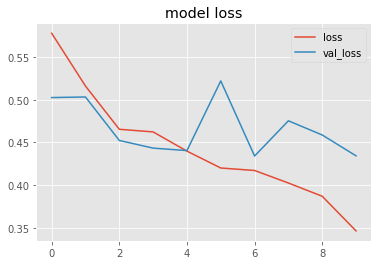

In [97]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.legend()
plt.show()

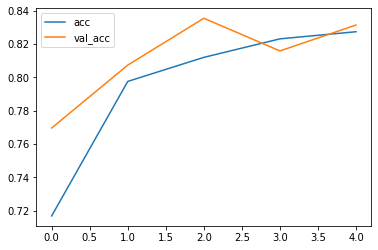

In [138]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.legend()
plt.show()

### Mobile Net

In [0]:
ALPHA = 1.0

In [187]:
#model building
input_tensor = Input(shape=(228,228,1) )
x2 = Conv2D(3, (3,3), padding='same', name="coords1")(input_tensor) 

model2 = MobileNet(input_shape=(228, 228, 3), include_top=False, alpha=ALPHA, weights = "imagenet") 

for layer in model2.layers:
    layer.trainable = False
    
x1 = model2(x2)
x = Dropout(0.5)(x)
x = Conv2D(3, (6,6), name="coords2")(x1)
x = Dropout(0.5)(x)


x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=input_tensor, outputs=x)

In [188]:
#print model summary
model2.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 228, 228, 1)]     0         
_________________________________________________________________
coords1 (Conv2D)             (None, 228, 228, 3)       30        
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
coords2 (Conv2D)             (None, 2, 2, 3)           110595    
_________________________________________________________________
dropout_59 (Dropout)         (None, 2, 2, 3)           0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 12)                0         
_________________________________________________________________
dense_65 (Dense)             (None, 128)               1664

In [0]:
#Compiling model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [190]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=4, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [191]:
#fitting model to traing set
r = model2.fit(
  X_train,
  y_train,
  batch_size=70,
  epochs=10,
  validation_data=(X_val,y_val),
  callbacks=[checkpoint, reduce_lr, stop],
  verbose=1
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 1.3522 - accuracy: 0.6613
Epoch 00001: val_accuracy improved from -inf to 0.78185, saving model to model-1.35.h5
90/90 [==============================] - 48s 529ms/step - loss: 1.3522 - accuracy: 0.6613 - val_loss: 0.5395 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.8164 - accuracy: 0.7230
Epoch 00002: val_accuracy improved from 0.78185 to 0.80741, saving model to model-0.82.h5
90/90 [==============================] - 47s 527ms/step - loss: 0.8164 - accuracy: 0.7230 - val_loss: 0.5101 - val_accuracy: 0.8074 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.6190 - accuracy: 0.7698
Epoch 00003: val_accuracy did not improve from 0.80741
90/90 [==============================] - 47s 524ms/step - loss: 0.6190 - accuracy: 0.7698 - val_loss: 0.5829 - val_accuracy: 0.7819 - lr: 0.0010
Epoch 4/10
90/90 [==============================] -

In [0]:
#Loading weights of best validation accuracy
model2.load_weights('model-0.30.h5')

In [216]:
#predicting one image from validation step
n=121
img=X_val[n].reshape(1,228,228,1)
k=model2.predict(img)
print(k)
print(y_val[n])

[[0.9999924]]
1


In [217]:
#Evaluate validation set and then print accuracy
results = model2.evaluate(X_val, y_val)
print('accuracy: ', results[1])

85/85 [==============================] - 7s 77ms/step - loss: 0.5153 - accuracy: 0.8193
accuracy:  0.8192592859268188


In [0]:
#Getting prediction of test set
prediction_test = model2.predict(X_test)

In [0]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((1000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [220]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred),'\n')
print(metrics.classification_report(y_test,pred))

accuracy : 0.8020
F1 score : 0.8325
precision score : 0.8159
recall score : 0.8497
Confusion Matrix:
 [[310 111]
 [ 87 492]] 

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       421
           1       0.82      0.85      0.83       579

    accuracy                           0.80      1000
   macro avg       0.80      0.79      0.80      1000
weighted avg       0.80      0.80      0.80      1000



In [221]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.876369693016463


In [222]:
#prediction of 1 image
n=1047
print("X_test shape = ",X_train.shape) #To see shape of X_test

x=X_train[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,228,228,1) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model2.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_train[n])

X_test shape =  (6300, 228, 228, 1)
Shape of x =  (228, 228, 1)
New Shape of x =  (1, 228, 228, 1)


Predicted review =  1
Actual value =  1


In [223]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [1.352181315422058, 0.8163520097732544, 0.6189776062965393, 0.5085605382919312, 0.3742290437221527, 0.30168598890304565, 0.27234265208244324, 0.2402999997138977, 0.23459134995937347, 0.22315408289432526], 'accuracy': [0.6612698435783386, 0.7230158448219299, 0.7698412537574768, 0.8107936382293701, 0.8539682626724243, 0.8776190280914307, 0.88698410987854, 0.9073016047477722, 0.9082539677619934, 0.9117460250854492], 'val_loss': [0.5394986271858215, 0.510090172290802, 0.582941472530365, 0.5653413534164429, 0.5037819147109985, 0.515320897102356, 0.5071996450424194, 0.5041027665138245, 0.5129035115242004, 0.5114420652389526], 'val_accuracy': [0.7818518280982971, 0.8074073791503906, 0.7818518280982971, 0.8025925755500793, 0.818148136138916, 0.8192592859268188, 0.8151851892471313, 0.818148136138916, 0.8118518590927124, 0.8166666626930237], 'lr': [0.001, 0.001, 0.001, 0.001, 0.00020000001, 0.00020000001, 0.00020000001, 4.0000003e-05, 4.0000003e-05, 8.000001e-06]}


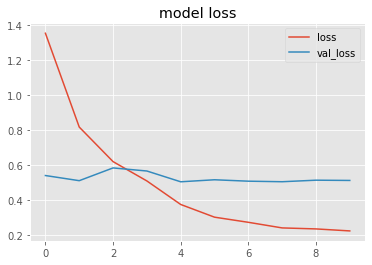

In [224]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.legend()
plt.show()

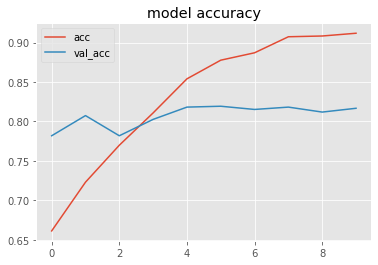

In [225]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.legend()
plt.show()

### ResNet

In [0]:
#model building
input_tensor = Input(shape=(228,228,1) )
x2 = Conv2D(3, (3,3), padding='same', name="coords1")(input_tensor) 

model3 = ResNet50(include_top=False, weights='imagenet', input_shape=(228, 228, 3))

for layer in model3.layers:
    layer.trainable = False

x1 = model3(x2)

x = Conv2D(3, (6,6), name="coords2")(x1)
x = Dropout(0.4)(x)


x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model3 = Model(inputs=input_tensor, outputs=x)

In [116]:
#model summary
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 228, 228, 1)]     0         
_________________________________________________________________
coords1 (Conv2D)             (None, 228, 228, 3)       30        
_________________________________________________________________
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
coords2 (Conv2D)             (None, 3, 3, 3)           221187    
_________________________________________________________________
dropout_20 (Dropout)         (None, 3, 3, 3)           0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 27)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               3584

In [0]:
#compiling model
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=4, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [120]:
#Fitting model
r = model3.fit(
  X_train,
  y_train,
  batch_size=70,
  epochs=10,
  validation_data=(X_val,y_val),
  callbacks=[checkpoint, reduce_lr, stop],
  verbose=1
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 1.2261 - accuracy: 0.5106
Epoch 00001: val_accuracy improved from -inf to 0.59259, saving model to model-1.23.h5
90/90 [==============================] - 135s 1s/step - loss: 1.2261 - accuracy: 0.5106 - val_loss: 0.6707 - val_accuracy: 0.5926 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.8487 - accuracy: 0.5275
Epoch 00002: val_accuracy improved from 0.59259 to 0.69259, saving model to model-0.85.h5
90/90 [==============================] - 133s 1s/step - loss: 0.8487 - accuracy: 0.5275 - val_loss: 0.6295 - val_accuracy: 0.6926 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.7878 - accuracy: 0.5486
Epoch 00003: val_accuracy did not improve from 0.69259
90/90 [==============================] - 133s 1s/step - loss: 0.7878 - accuracy: 0.5486 - val_loss: 0.6474 - val_accuracy: 0.6089 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - ETA: 

In [165]:
#predicting one image from validation step
n=121
img=X_val[n].reshape(1,228,228,1)
k=model3.predict(img)
print(k)
print(y_val[n])

[[0.79931515]]
1


In [166]:
#Evaluate validation set and then print accuracy
results = model3.evaluate(X_val, y_val)
print('accuracy: ', results[1])

85/85 [==============================] - 20s 237ms/step - loss: 0.5215 - accuracy: 0.7500
accuracy:  0.75


In [0]:
#Getting prediction of test set
prediction_test = model3.predict(X_test)

In [0]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((1000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [169]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred),'\n')
print(metrics.classification_report(y_test,pred))

accuracy : 0.7470
F1 score : 0.7981
precision score : 0.7418
recall score : 0.8636
Confusion Matrix:
 [[247 174]
 [ 79 500]] 

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       421
           1       0.74      0.86      0.80       579

    accuracy                           0.75      1000
   macro avg       0.75      0.73      0.73      1000
weighted avg       0.75      0.75      0.74      1000



In [127]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.8327897636600085


In [128]:
#prediction of 1 image
n=104
print("X_test shape = ",X_train.shape) #To see shape of X_test

x=X_train[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,228,228,1) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model3.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_train[n])

X_test shape =  (6300, 228, 228, 1)
Shape of x =  (228, 228, 1)
New Shape of x =  (1, 228, 228, 1)


Predicted review =  1
Actual value =  1


In [129]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [1.2261298894882202, 0.8486518263816833, 0.7877516746520996, 0.719620406627655, 0.6527297496795654, 0.6603070497512817, 0.6018590331077576, 0.5880072116851807, 0.5840732455253601, 0.540191113948822], 'accuracy': [0.5106348991394043, 0.5274603366851807, 0.5485714077949524, 0.5969841480255127, 0.6453968286514282, 0.6592063307762146, 0.6936507821083069, 0.7099999785423279, 0.7155555486679077, 0.7404761910438538], 'val_loss': [0.6706786155700684, 0.629508376121521, 0.6473796963691711, 0.5852795839309692, 0.5822733640670776, 0.6097597479820251, 0.5434492826461792, 0.5589173436164856, 0.5536693334579468, 0.521477997303009], 'val_accuracy': [0.5925925970077515, 0.6925926208496094, 0.6088888645172119, 0.7188888788223267, 0.7322221994400024, 0.7044444680213928, 0.7314814925193787, 0.7462962865829468, 0.7233333587646484, 0.75], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001]}


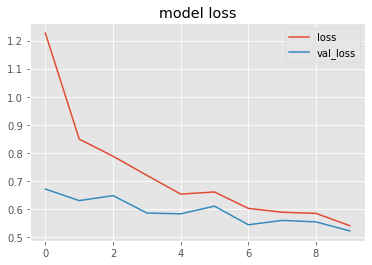

In [130]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.legend()
plt.show()

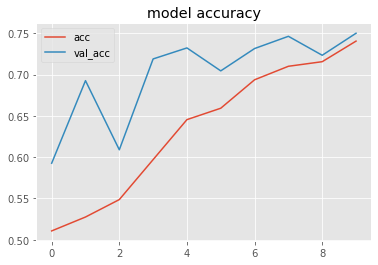

In [131]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.legend()
plt.show()

### VGG19 

In [132]:
#model building
input_tensor = Input(shape=(228,228,1) )
x2 = Conv2D(3, (3,3), padding='same', name="coords1")(input_tensor) 

model4 = VGG19(include_top=False, input_shape=(228, 228, 3), weights = "imagenet")


for layer in model4.layers:
    layer.trainable = False
    
x1 = model4(x2)

x = Conv2D(3, (6,6), name="coords2")(x1)
x = Dropout(0.4)(x)


x = Flatten()(x)

x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='sigmoid')(x)

model4 = Model(inputs=input_tensor, outputs=x)

80142336/80134624 [==============================] - 1s 0us/step


In [133]:
#printing model summary
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 228, 228, 1)]     0         
_________________________________________________________________
coords1 (Conv2D)             (None, 228, 228, 3)       30        
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
coords2 (Conv2D)             (None, 2, 2, 3)           55299     
_________________________________________________________________
dropout_22 (Dropout)         (None, 2, 2, 3)           0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               1664

In [0]:
#Compiling the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [135]:
#Defining callbacks
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
stop = EarlyStopping(monitor="loss", patience=4, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6, verbose=1, mode="min") 

In [136]:
#fitting model to traing set
r = model4.fit(
  X_train,
  y_train,
  batch_size=70,
  epochs=10,
  validation_data=(X_val,y_val),
  callbacks=[checkpoint, reduce_lr, stop],
  verbose=1
)

Epoch 1/10
90/90 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.6629
Epoch 00001: val_accuracy improved from -inf to 0.75185, saving model to model-0.61.h5
90/90 [==============================] - 183s 2s/step - loss: 0.6148 - accuracy: 0.6629 - val_loss: 0.4958 - val_accuracy: 0.7519 - lr: 0.0010
Epoch 2/10
90/90 [==============================] - ETA: 0s - loss: 0.5373 - accuracy: 0.7444
Epoch 00002: val_accuracy did not improve from 0.75185
90/90 [==============================] - 183s 2s/step - loss: 0.5373 - accuracy: 0.7444 - val_loss: 0.5100 - val_accuracy: 0.7444 - lr: 0.0010
Epoch 3/10
90/90 [==============================] - ETA: 0s - loss: 0.4998 - accuracy: 0.7679
Epoch 00003: val_accuracy improved from 0.75185 to 0.76148, saving model to model-0.50.h5
90/90 [==============================] - 183s 2s/step - loss: 0.4998 - accuracy: 0.7679 - val_loss: 0.4842 - val_accuracy: 0.7615 - lr: 0.0010
Epoch 4/10
90/90 [==============================] - ETA: 

In [137]:
#predicting one image from validation step
n=121
img=X_val[n].reshape(1,228,228,1)
k=model4.predict(img)
print(k)
print(y_val[n])

[[0.9681045]]
1


In [138]:
#Evaluate validation set and then print accuracy
results = model4.evaluate(X_val, y_val)
print('accuracy: ', results[1])

85/85 [==============================] - 32s 371ms/step - loss: 0.4587 - accuracy: 0.7867
accuracy:  0.7866666913032532


In [0]:
#Getting prediction of test set
prediction_test = model4.predict(X_test)

In [0]:
#Set threshold
#we want the value to be either 0 or 1
pred=np.zeros((1000,))
count=0
for i in prediction_test:
    if i>0.5:  #Got .5 after many hit and try
        pred[count]=1
    
    else:
        pred[count]=0
    
    count+=1

#Threshold is 0.5

In [141]:
#print accuracy score, f1 score, precision, recall and classification report
print("accuracy : {0:.4f}".format(accuracy_score(y_test,pred)))
print("F1 score : {0:.4f}".format(f1_score(y_test,pred)))
print("precision score : {0:.4f}".format(precision_score(y_test,pred)))
print("recall score : {0:.4f}".format(recall_score(y_test,pred)))
print('Confusion Matrix:\n',confusion_matrix(y_test,pred),'\n')
print(metrics.classification_report(y_test,pred))

accuracy : 0.7870
F1 score : 0.8206
precision score : 0.8010
recall score : 0.8411
Confusion Matrix:
 [[300 121]
 [ 92 487]] 

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       421
           1       0.80      0.84      0.82       579

    accuracy                           0.79      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.79      0.79      0.79      1000



In [142]:
#print AUC for train set
aucs = []
for j in range(6):
    auc = roc_auc_score(y_test, prediction_test)
    aucs.append(auc)
print(np.mean(aucs))

0.8604236151280568


In [147]:
#prediction of 1 image
n=321
print("X_test shape = ",X_test.shape) #To see shape of X_test

x=X_test[n]  #Put test value in x
print("Shape of x = ",x.shape)
#AS you can see it is out of shape when comared to x_test because it is a single value therefore we need to reshape it

x2=x.reshape(1,228,228,1) #Reshape to (1,300) so to put in our model if not done this step it will throw error as our model accept this shape only

print("New Shape of x = ",x2.shape) #Cross check step to see our new shape

P=model4.predict(x2) #predict x based on our model

P2 = 1 if P>0.5 else 0  #Setting threshold if value less than 0.5 it is -ve review otherwise poistive

print("\n")
print("Predicted review = ",P2) #predicted review
print("Actual value = ",y_test[n])

X_test shape =  (1000, 228, 228, 1)
Shape of x =  (228, 228, 1)
New Shape of x =  (1, 228, 228, 1)


Predicted review =  1
Actual value =  1


In [144]:
#To see what out model stores info so that these can be plotted
print(r.history)

{'loss': [0.6148116588592529, 0.5372610688209534, 0.4998364746570587, 0.4949764013290405, 0.47462666034698486, 0.46865415573120117, 0.4272306263446808, 0.42659759521484375, 0.4243854880332947, 0.40916046500205994], 'accuracy': [0.6628571152687073, 0.7444444298744202, 0.7679365277290344, 0.7712698578834534, 0.7846031785011292, 0.7804762125015259, 0.8126984238624573, 0.8136507868766785, 0.8122222423553467, 0.8231745958328247], 'val_loss': [0.4958477020263672, 0.5099705457687378, 0.4841715097427368, 0.4706335961818695, 0.47079232335090637, 0.4793902039527893, 0.46030381321907043, 0.4812871515750885, 0.46601301431655884, 0.4586816430091858], 'val_accuracy': [0.7518518567085266, 0.7444444298744202, 0.7614814639091492, 0.7696296572685242, 0.7707407474517822, 0.7681481242179871, 0.7811111211776733, 0.7781481742858887, 0.7844444513320923, 0.7866666913032532], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.00020000001, 0.00020000001, 0.00020000001, 4.0000003e-05]}


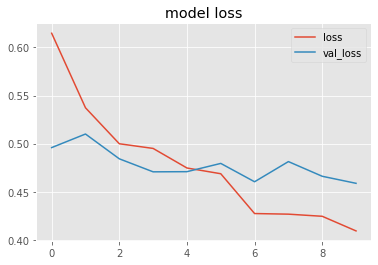

In [145]:
# plot model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title('model loss')
plt.legend()
plt.show()

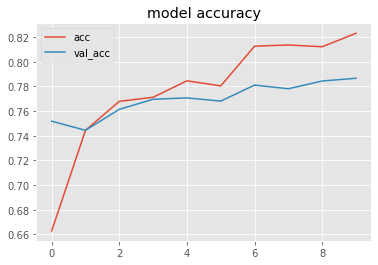

In [146]:
#plot model accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.title('model accuracy')
plt.legend()
plt.show()

CHEXNET

In [163]:
densenet = DenseNet121(
    #weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    #weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

shape_input_2 = (IMAGE_HEIGHT,IMAGE_WIDTH,1)
model_chex = Sequential()
model_chex.add(Conv2D(3,kernel_size=(3,3),activation='relu',input_shape=shape_input_2))
model_chex.add(Conv2D(3,kernel_size=(3,3),activation='relu'))
model_chex.add(densenet)
model_chex.add(Flatten())
model_chex.add(BatchNormalization())
model_chex.add(Dense(64, activation='relu'))
model_chex.add(Dropout(0.3))
model_chex.add(BatchNormalization())
model_chex.add(Dense(32, activation='relu'))
model_chex.add(Dropout(0.2))
model_chex.add(BatchNormalization())
model_chex.add(Dense(16, activation='relu'))
model_chex.add(Dropout(0.1))
model_chex.add(BatchNormalization())
model_chex.add(Dense(4, activation='relu'))
model_chex.add(Dropout(0.1))
model_chex.add(BatchNormalization())
model_chex.add(Dense(1, activation='sigmoid'))
#model_chex.load_weights("/content/drive/My Drive/Colab Notebooks/Capstone Project/model_chex_1_weights.h5")
#sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.03)
sgd_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_chex.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_chex.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 226, 226, 3)       30        
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 224, 224, 3)       84        
_________________________________________________________________
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_17 (Flatten)         (None, 50176)             0         
_________________________________________________________________
batch_normalization_41 (Batc (None, 50176)             200704    
_________________________________________________________________
dense_56 (Dense)             (None, 64)                3211328   
_________________________________________________________________
dropout_48 (Dropout)         (None, 64)              

In [164]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_accuracy", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1)
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=4,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True

history_chex=model_chex.fit(X_train,y_train,
          validation_data=(X_val,y_val),
          callbacks=[early_stopping_monitor ,checkpoint],
          epochs=10,
          batch_size=63)
          #steps_per_epoch=50)


Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.6495
Epoch 00001: val_accuracy improved from -inf to 0.57556, saving model to model-0.67.h5
100/100 [==============================] - 153s 2s/step - loss: 0.6720 - accuracy: 0.6495 - val_loss: 0.6865 - val_accuracy: 0.5756
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.5597 - accuracy: 0.7248
Epoch 00002: val_accuracy did not improve from 0.57556
100/100 [==============================] - 147s 1s/step - loss: 0.5597 - accuracy: 0.7248 - val_loss: 0.6856 - val_accuracy: 0.5496
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.4914 - accuracy: 0.7705
Epoch 00003: val_accuracy did not improve from 0.57556
100/100 [==============================] - 148s 1s/step - loss: 0.4914 - accuracy: 0.7705 - val_loss: 0.7063 - val_accuracy: 0.5741
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.4557 - accuracy: 0.7930
Epoch 00004: val_accura

In [170]:
y_pred_chex=(model_chex.predict(X_test) > 0.5).astype("int32")
print('Confusion Matrix:\n',confusion_matrix(y_test,y_pred_chex),'\n')
print('Classification Report:\n',classification_report(y_test,y_pred_chex),'\n')
print('Accuracy Score:\n',accuracy_score(y_test,y_pred_chex),'\n')
eval_chex=model_chex.evaluate(X_test,y_test,verbose=0)
print('Model Evaluation Loss :\n',eval_chex[0])
print('Model Evaluation Accuracy :\n',eval_chex[1])

Confusion Matrix:
 [[224 197]
 [ 44 535]] 

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.53      0.65       421
           1       0.73      0.92      0.82       579

    accuracy                           0.76      1000
   macro avg       0.78      0.73      0.73      1000
weighted avg       0.78      0.76      0.75      1000
 

Accuracy Score:
 0.759 

Model Evaluation Loss :
 0.6337908506393433
Model Evaluation Accuracy :
 0.7590000033378601


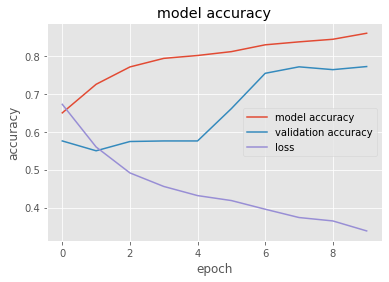

In [171]:
style.use('ggplot')
plt.plot(history_chex.history['accuracy'],label='model accuracy')
plt.plot(history_chex.history['val_accuracy'],label='validation accuracy')
plt.plot(history_chex.history['loss'],label='loss')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()